In [1]:
using Gen, Plots, LinearAlgebra

In [379]:
function getRotationMatrix(theta)
    return [cos(theta) -sin(theta); sin(theta) cos(theta)]
end

getRotationMatrix (generic function with 1 method)

In [380]:
function makeBox(theta, scale)
    normals = [[0.0, -1.0], [1.0, 0.0], [0.0, 1.0], [-1.0, 0.0]]
    corners = [[1.0,1.0], [-1.0,1.0], [-1.0,-1.0], [1.0,-1.0]]
    for i in 1:4
        normals[i] = getRotationMatrix(theta) * normals[i]
        corners[i] = getRotationMatrix(theta) * corners[i] * scale
    end
    box = vcat(normals, corners)
    return box
end

makeBox (generic function with 1 method)

In [381]:
function isInBox(box, point, scale)
    ABn = box[1] # normal defining AB
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    # dot product with normal (check which side of the hyperspace the point is on)
    mAB = Transpose(ABn) * point + scale
    mBC = Transpose(BCn) * point + scale
    mCD = Transpose(CDn) * point + scale
    mDA = Transpose(DAn) * point + scale

    # get around floating point error
    epsilon = 0.0000001
    if mAB > -epsilon && mAB < epsilon
        mAB = 0.0
    end
    if mBC > -epsilon && mBC < epsilon
        mBC = 0.0
    end
    if mCD > -epsilon && mCD < epsilon
        mCD = 0.0
    end
    if mDA > -epsilon && mDA < epsilon
        mDA = 0.0
    end
    
    # dot product should be => 0 for all if the point is in the box
    if mAB < 0 
        return false
    end
     if mBC < 0
        return false
    end
    if mCD < 0
        return false
    end
    if mDA < 0
        return false
    end
    return true
    
end

isInBox (generic function with 1 method)

In [382]:
# find the point of collision, normal at collision, and time of collision
# time of collision = Inf if there is no collision
function findIntersectionWithTrajectory(box, scale, O, V)
    # normals for each side of box
    ABn = box[1] # normal defining AB (facing inward)
    BCn = box[2]
    CDn = box[3]
    DAn = box[4]

    tAB = Inf
    tBC = Inf
    tBC = Inf
    tDA = Inf

    # time of collision with each side of box
    tAB = (-scale - (ABn[1]* O[1]) - (ABn[2]* O[2]))/(ABn[1]*V[1] + ABn[2]*V[2])
    tBC = (-scale - (BCn[1]* O[1]) - (BCn[2]* O[2]))/(BCn[1]*V[1] + BCn[2]*V[2])
    tCD = (-scale - (CDn[1]* O[1]) - (CDn[2]* O[2]))/(CDn[1]*V[1] + CDn[2]*V[2])
    tDA = (-scale - (DAn[1]* O[1]) - (DAn[2]* O[2]))/(DAn[1]*V[1] + DAn[2]*V[2])

    # filter out "collision" if it happens in negative time
    if tAB == -Inf || tAB < 0 
        tAB = Inf
    end
    if tBC == -Inf || tBC < 0
        tBC = Inf
    end
    if tCD == -Inf || tCD < 0
        tCD = Inf
    end
    if tDA == -Inf || tDA < 0
        tDA = Inf
    end

    # find closest positive time of collision AKA the side of the box that the ball collides with
    current = Inf
    p = [Inf;Inf]
    n = [0.0;0.0]
    if tAB < current
        temp_p = O + V*tAB
        if isInBox(box, temp_p, scale)
            current = tAB
            p = O + V*tAB
            n = ABn
        end
    end
    if tBC < tAB
        temp_p = O + V*tBC
        if isInBox(box, temp_p, scale)
            current = tBC
            p = O + V*tBC
            n = BCn
        end
    end
    if tCD < current
        temp_p = O + V*tCD
        if isInBox(box, temp_p, scale)
            current = tCD
            p = O + V*tCD
            n = CDn
        end
    end
    if tDA < current
        temp_p = O + V*tDA
        if isInBox(box, temp_p, scale)
            current = tCD
            p = O + V*tCD
            n = DAn
        end
    end

    return (p, -n, current) #(point of intersection, -n so the n points outward, time of intersection)
end

findIntersectionWithTrajectory (generic function with 1 method)

In [874]:
# get the velocity after colliding with the object
function getOutVector(V_in, p, n)
    O_out = p 
    V_out = V_in - 2 * (Transpose(V_in) * n) * n # velocity after hitting the object
    return O_out, V_out
end

getOutVector (generic function with 1 method)

In [875]:
# putting it all together
function getOutTrajectory(box, scale, O_in, V_in)
    p,n,t_out = findIntersectionWithTrajectory(box, scale, O_in, V_in) 
    O_out, V_out = getOutVector(V_in, p, n)
    return O_out, V_out, t_out
end

getOutTrajectory (generic function with 1 method)

In [876]:
@gen function line_model(O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y)
    # O_in[1] = ({:O_in_x} ~ normal(O_in[1], 0.1))
    # O_in[2] = ({:O_in_y} ~ normal(O_in[2], 0.1))
    V_in[1] = ({:V_in_x} ~ normal(V_in[1], 0.05))
    V_in[2] = ({:V_in_y} ~ normal(V_in[2], 0.05))

    V_out[1] = ({:V_out_x} ~ normal(V_out[1], 0.05))
    V_out[2] = ({:V_out_y} ~ normal(V_out[2], 0.05))
    function y_in(t)
        return O_in + V_in * t
    end

    function y_out(t)
        return O_out + V_out * (t - t_out)
    end
    i_in_count= 0 #how many time steps before hit
    i_out_count = 0 #how many time steps after hit
    for (i, t) in enumerate(ts)
        if t < t_out #trajectory before hit object
            i_in_count = i
            ({(:x_in, i)} ~ normal(y_in(t)[1], jitter_x))
            ({(:y_in, i)} ~ normal(y_in(t)[2], jitter_y))
        else #trajectory after hit object
            i_out_count += 1
            ({(:x_out, i_out_count)} ~ normal(y_out(t)[1], jitter_x))
            ({(:y_out, i_out_count)} ~ normal(y_out(t)[2], jitter_y))
        end
    end

    return y_in, y_out, i_in_count, i_out_count
end;

In [877]:
# no distinction between in and out trajectory for the random generated things
@gen function line_model2(O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y)
    V_in[1] = ({:V_in_x} ~ normal(V_in[1], 0.05))
    V_in[2] = ({:V_in_y} ~ normal(V_in[2], 0.1))

    V_out[1] = ({:V_out_x} ~ normal(V_out[1], 0.05))
    V_out[2] = ({:V_out_y} ~ normal(V_out[2], 0.05))
    function y_in(t)
        return O_in + V_in * t
    end

    function y_out(t)
        return O_out + V_out * (t - t_out)
    end
    i_in_count= 0 #how many time steps before hit
    i_out_count = 0 #how many time steps after hit
    for (i, t) in enumerate(ts)
        if t < t_out #trajectory before hit object
            i_in_count = i
            ({(:x, i)} ~ normal(y_in(t)[1], jitter_x))
            ({(:y, i)} ~ normal(y_in(t)[2], jitter_y))
        else #trajectory after hit object
            i_out_count += 1
            ({(:x, i)} ~ normal(y_out(t)[1], jitter_x))
            ({(:y, i)} ~ normal(y_out(t)[2], jitter_y))
        end
    end

    return y_in, y_out, i_in_count, i_out_count
end;

In [878]:
function render_trace(trace, box; show_data=true)
    # Pull out ts from the trace
    O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y = get_args(trace)
    
    # Pull out the return value, useful for plotting
    y_in, y_out, i_in_count, i_out_count = get_retval(trace)
    
    fig = plot(color="black", label=nothing,
                xlim=(-15, 15), ylim=(-15, 15))

    test_xs = collect(range(-20, stop=20, length=1000))
    # fig = plot(test_xs, map(y_in, test_xs), color="black", alpha=0.5, label=nothing,
    #              xlim=(-15, 15), ylim=(-15, 15))
    plot!(map(x -> x[1],map(y_in, test_xs)), map(x -> x[2],map(y_in, test_xs)), color="black", alpha=0.5, label=nothing)
    plot!(map(x -> x[1],map(y_out, test_xs)), map(x -> x[2],map(y_out, test_xs)), color="black", alpha=0.5, label=nothing)
    
    # map(x -> x[1],map(y_in, test_xs))

    
    # plot the box
    A = box[5]
    B = box[6]
    C = box[7]
    D = box[8]
    E = box[5]
    plot!([A[1],B[1],C[1],D[1],E[1]],[A[2],B[2],C[2],D[2],E[2]],
      color=:red, linewidth=2, linestyle=:solid, label="Collision box")


    # plot the path
    if show_data
        x_in = [trace[(:x_in, i)] for i=1:i_in_count]
        y_in = [trace[(:y_in, i)] for i=1:i_in_count]
        scatter!(x_in, y_in, c="blue", label="In trajectory")

        if i_out_count > 0
            x_out = [trace[(:x_out, i)] for i=1:i_out_count]
            y_out = [trace[(:y_out, i)] for i=1:i_out_count]
            scatter!(x_out, y_out, c="green", label="Out trajectory")
        end
        
    end
    
    return fig
end;

In [879]:
# no distinction between in and out
function render_trace2(trace, box; show_data=true)
    # Pull out ts from the trace
    O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y = get_args(trace)
    
    # Pull out the return value, useful for plotting
    y_in, y_out, i_in_count, i_out_count = get_retval(trace)
    
    fig = plot(color="black", label=nothing,
                xlim=(-15, 15), ylim=(-15, 15))

    test_xs = collect(range(-20, stop=20, length=1000))
    # fig = plot(test_xs, map(y_in, test_xs), color="black", alpha=0.5, label=nothing,
    #              xlim=(-15, 15), ylim=(-15, 15))
    # plot!(map(x -> x[1],map(y_in, test_xs)), map(x -> x[2],map(y_in, test_xs)), color="black", alpha=0.5, label=nothing)
    # plot!(map(x -> x[1],map(y_out, test_xs)), map(x -> x[2],map(y_out, test_xs)), color="black", alpha=0.5, label=nothing)
    
    # map(x -> x[1],map(y_in, test_xs))

    
    # plot the box
    A = box[5]
    B = box[6]
    C = box[7]
    D = box[8]
    E = box[5]
    plot!([A[1],B[1],C[1],D[1],E[1]],[A[2],B[2],C[2],D[2],E[2]],
      color=:red, linewidth=2, linestyle=:solid, label="Collision box")


    # plot the path
    if show_data
        x_in = [trace[(:x, i)] for i=1:i_in_count]
        y_in = [trace[(:y, i)] for i=1:i_in_count]
        scatter!(x_in, y_in, c="blue", label="In trajectory")

        if i_out_count > 0
            x_out = [trace[(:x, i)] for i=i_in_count:i_in_count+i_out_count]
            y_out = [trace[(:y, i)] for i=i_in_count:i_in_count+i_out_count]
            scatter!(x_out, y_out, c="green", label="Out trajectory")
        end
        
    end
    
    return fig
end;

In [880]:
function getTrajectoryPoints(trace, i_in_count, i_out_count)
    in_traj = [(trace[(:x_in, i)],trace[(:y_in, i)])  for i=1:i_in_count] # in-trajectory
    out_traj = []
    if i_out_count >= 0
        out_traj = [(trace[(:x_out, i)],trace[(:y_out, i)])  for i=1:i_out_count] #out-trajectory
    end
    all_traj = vcat(in_traj, out_traj) # all trajectory
    
    return in_traj, out_traj, all_traj
end

getTrajectoryPoints (generic function with 1 method)

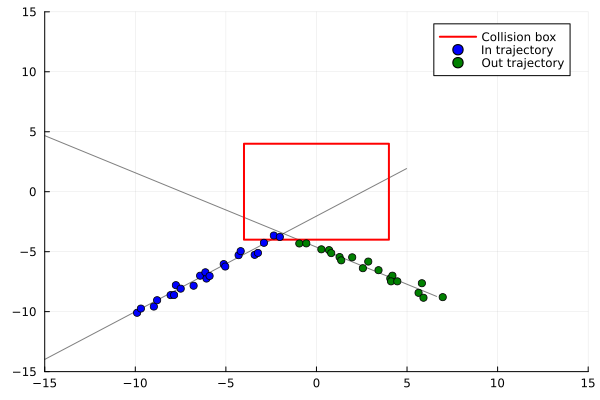

In [881]:
scale = 4
theta =  0 * 0.0174533 # degrees to radians
box = makeBox(theta,scale) 
O_in = [-10.0;-10.0]
V_in = normalize([3.0,2.0])
O_out, V_out, t_out = getOutTrajectory(box, scale, O_in, V_in)

ts = [0:0.5:20;]
jitter_x = 0.25
jitter_y = 0.25
y_in, y_out, i_in_count, i_out_count = line_model(O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y)
trace = Gen.simulate(line_model, (O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y));
choices = Gen.get_choices(trace);
in_traj, out_traj, all_traj = getTrajectoryPoints(trace, i_in_count, i_out_count) # get can just the in-points, the out-points, or all points in trajectory
render_trace(trace, box)

In [882]:
function do_inference(model, x_in, y_in, x_out, y_out, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(y_in)
        observations[(:y_in, i)] = y
    end
    for (i, x) in enumerate(x_in)
        observations[(:x_in, i)] = x
    end
    for (i, y) in enumerate(y_out)
        observations[(:y_out, i)] = y
    end
    for (i, x) in enumerate(x_out)
        observations[(:x_out, i)] = x
    end
    
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y), observations, amount_of_computation);
    return trace
end;

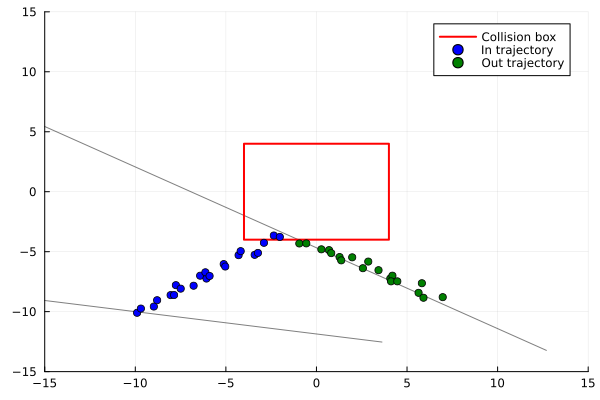

In [883]:
trace2 = do_inference(line_model, map(x -> x[1],in_traj), map(x -> x[2],in_traj), map(x -> x[1],out_traj), map(x -> x[2],out_traj), 100, O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y);
render_trace(trace2, box)
# render_trace(trace2)

In [843]:
function getTrajectoryPoints2(trace, i_in_count, i_out_count)
    in_traj = [(trace[(:x, i)],trace[(:y, i)])  for i=1:i_in_count] # in-trajectory
    out_traj = []
    if i_out_count >= 0
        out_traj = [(trace[(:x, i)],trace[(:y, i)]) for i=i_in_count:i_in_count+i_out_count] #out-trajectory
    end
    all_traj = vcat(in_traj, out_traj) # all trajectory
    
    return in_traj, out_traj, all_traj
end


getTrajectoryPoints2 (generic function with 1 method)

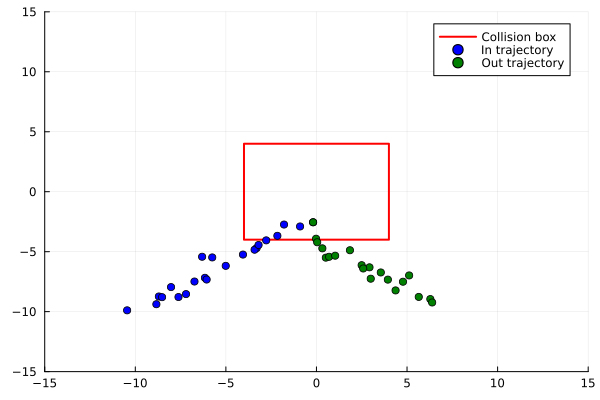

In [848]:
scale = 4
theta =  0 * 0.0174533 # degrees to radians
box = makeBox(theta,scale) 
O_in = [-10.0;-10.0]
V_in = normalize([3.0,2.0])
O_out, V_out, t_out = getOutTrajectory(box, scale, O_in, V_in)

ts = [0:0.5:20;]
jitter_x = 0.5
jitter_y = 0.5
y_in, y_out, i_in_count, i_out_count = line_model2(O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y)
trace = Gen.simulate(line_model2, (O_in, V_in, t_out, O_out, V_out, ts, jitter_x, jitter_y));
choices = Gen.get_choices(trace)
in_traj, out_traj, all_traj = getTrajectoryPoints2(trace, i_in_count, i_out_count)
render_trace2(trace, box)

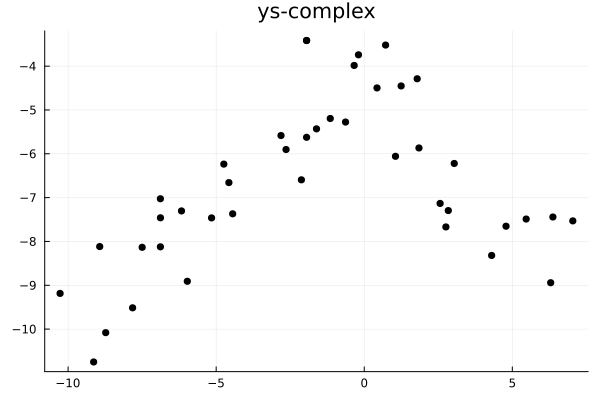

In [649]:
xs = map(x -> x[1],all_traj);
ys = map(x -> x[2],all_traj);
complex_plot = scatter(xs, ys, color="black", label=nothing, title="ys-complex")

In [647]:
struct Interval
    l::Float64
    u::Float64
end

In [648]:
abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

In [650]:
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if ({:isleaf} ~ bernoulli(0.7))
        value = ({:value} ~ normal(0, 1))
        return LeafNode(value, interval)
    else
        frac = ({:frac} ~ beta(2, 2))
        mid  = l + (u - l) * frac
        # Call generate_segments recursively!
        # Because we will call it twice -- one for the left 
        # child and one for the right child -- we use
        # addresses to distinguish the calls.
        left = ({:left} ~ generate_segments(l, mid))
        right = ({:right} ~ generate_segments(mid, u))
        return InternalNode(left, right, interval)
    end
end;

In [651]:
function render_node!(node::LeafNode)
    plot!([node.interval.l, node.interval.u], [node.value, node.value], label=nothing, linewidth=5)
end

function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;

In [652]:
function render_segments_trace(trace; xlim=(0,1))
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=(-3, 3))
    render_node!(node)
    return fig
end;

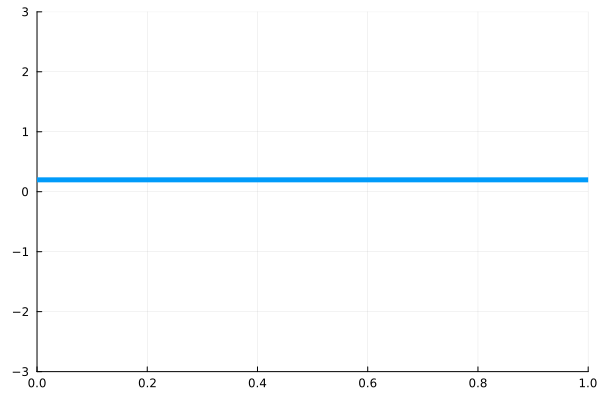

In [728]:
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
render_segments_trace(traces[3])